# **Assignment 2**
Zheyu Liu 260784914; 

Sandra Deng 260770487;



## Setup and Import

In [2]:
!pip install opencv-contrib-python==3.4.2.16

     |████████████████████████████████| 30.6MB 142kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def get_img(img_name):
  img_basedir = '/content/drive/MyDrive/ECSE415_Assignment/a2_images/'

  img_dir = os.path.join(img_basedir, img_name)
  img = mpimg.imread(img_dir)
  return img

## Question 3: Image Stiching

### function implementation

Compute SIFT Points

Find and Display 20 Best Matches

RANSC

Linear Blending

**reference**:
1. tutorial 4 code
2. opencv doc https://docs.opencv.org/master/d1/de0/tutorial_py_feature_homography.html

In [13]:
def get_panoramic(src_img, dst_img, window_size=10, is_stich_to_right=True):
  dst_img_original = dst_img

  if is_stich_to_right:
    # pad right image
    dst_img = np.pad(dst_img_original, ((0, 0), (src_img.shape[1], 0), (0, 0)))

  # SIFT feature extraction
  sift = cv2.xfeatures2d.SIFT_create()
  src_keypoints,src_descriptors = sift.detectAndCompute(src_img, None)
  dst_keypoints,dst_descriptors = sift.detectAndCompute(dst_img, None)
  
  # matching SIFT key points
  bf = cv2.BFMatcher()
  matches = bf.match(src_descriptors, dst_descriptors) # query, train
  matches = sorted(matches, key=lambda x:x.distance)
  matched_result = cv2.drawMatches(src_img, src_keypoints, dst_img, dst_keypoints, matches[:20], None, flags=2)

  # RANSAC
  thres = 0.2 * matches[-1].distance
  good_matches = []
  for m in matches:
    if m.distance < thres:
      good_matches.append(m)

  # points in matches
  src_mp = np.float32([src_keypoints[m.queryIdx].pt for m in good_matches])
  dst_mp = np.float32([dst_keypoints[m.trainIdx].pt for m in good_matches])
 
  H, _ = cv2.findHomography(src_mp, dst_mp, cv2.RANSAC, 4.0)
  wimg = cv2.warpPerspective(src_img, H, (src_img.shape[1]+dst_img_original.shape[1], src_img.shape[0]))
  max_h = np.amax(np.nonzero(wimg)[0])
  min_h = np.amin(np.nonzero(wimg)[0])
  blend_h_high = min(max_h, dst_img.shape[0])
  blend_h_low = max(min_h, 0)

  # linear blending
  if is_stich_to_right:
    stich_x = wimg.shape[1]-dst_img_original.shape[1]
    window_low = stich_x
    window_high = stich_x + window_size
    weight_distri = np.array([np.array([1., 1., 1.]) * w for w in np.arange(1., 0, -1/window_size)])

    wimg[blend_h_low:blend_h_high, window_low:window_high, :] = (weight_distri * wimg[blend_h_low:blend_h_high, window_low:window_high, :] + \
                                                                 (1 - weight_distri) * dst_img_original[blend_h_low:blend_h_high, 0:window_size, :])
    wimg[:, window_high:, :] = dst_img_original[:, window_size:, :]
    
  else:
    stich_x = dst_img_original.shape[1]
    window_low = stich_x - window_size
    window_high = stich_x
    weight_distri = np.array([np.array([1., 1., 1.]) * w for w in np.arange(1., 0, -1/window_size)])
    wimg[blend_h_low:blend_h_high, window_low:window_high, :] = ((1 - weight_distri) * wimg[blend_h_low:blend_h_high, window_low:window_high, :] + \
                                                                 (weight_distri) * dst_img[blend_h_low:blend_h_high, -window_size:, :])
    wimg[:, :window_low, :] = dst_img_original[:, :window_low, :]

  # output image
  plt.figure(figsize=(20,10))
  plt.subplot(211), plt.imshow(matched_result)
  plt.title("Matched Keypoints"), plt.xticks([]), plt.yticks([])
  plt.subplot(212)
  plt.imshow(wimg)
  plt.title("Panoramic image"), plt.xticks([]), plt.yticks([])
  plt.show()

  return wimg

### 1) 2) 3) 4)

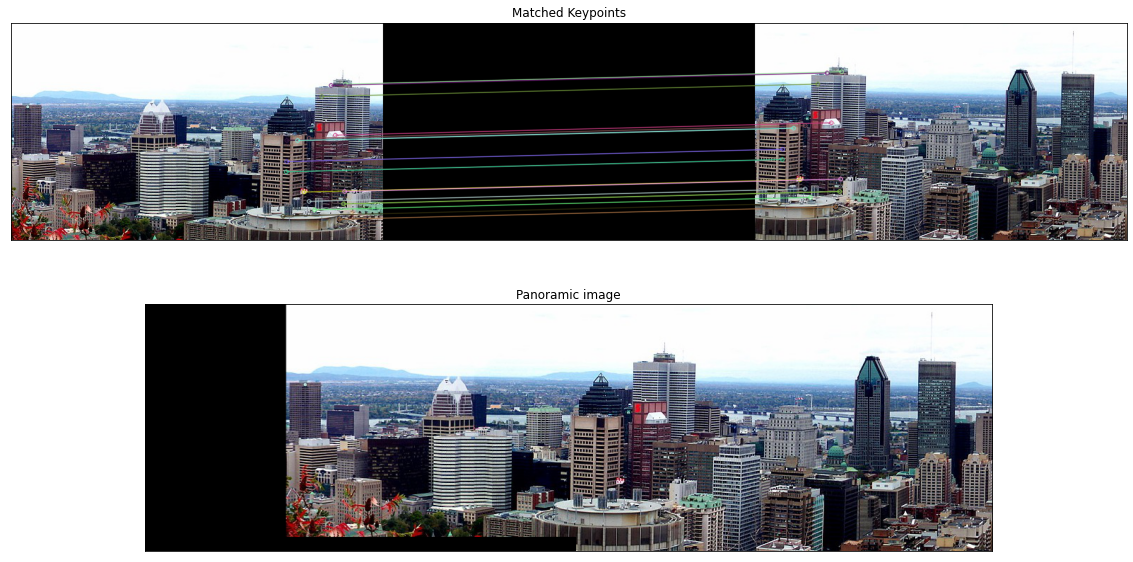

In [14]:
montreal1 = get_img('1Montreal.jpg')
montreal2 = get_img('2Montreal.jpg')

montreal12 = get_panoramic(montreal1, montreal2, 10, True)

### 5) 6) 7) 8)

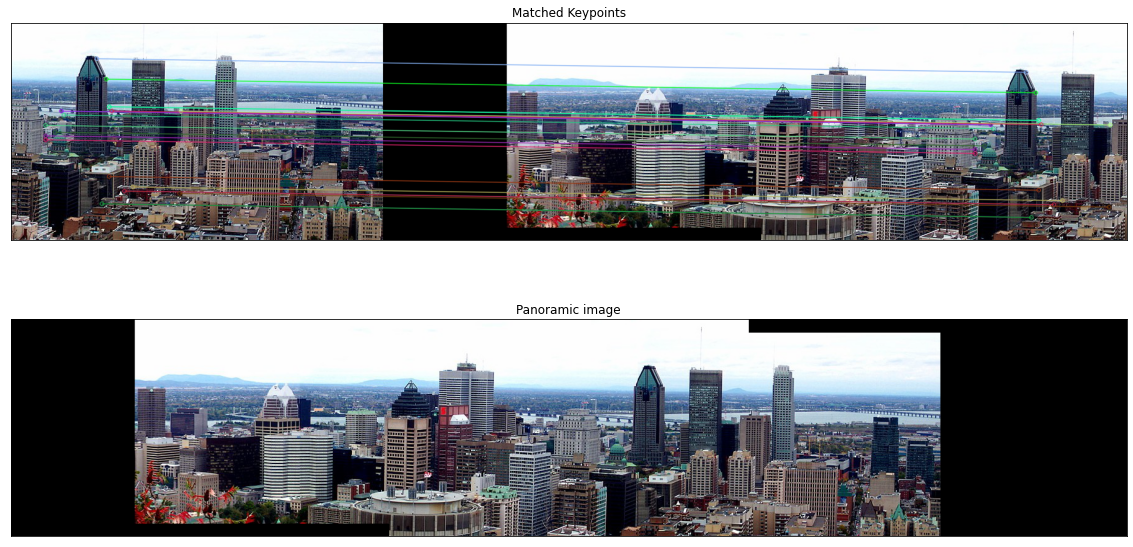

In [15]:
montreal3 = get_img('3Montreal.jpg')
panoramic = get_panoramic(montreal3, montreal12, 10, False)

## Question 4: Template Matching

### template_matching()

function implementation

In [21]:
def template_matching(ref_img, template_img):
  h, w, _ = template_img.shape
  ref_h, ref_w, _ = ref_img.shape
  ref_ssd = np.zeros((ref_h-h, ref_w-w))
  for x in range(ref_h-h):
    for y in range(ref_w-w):
      ref_ssd[x, y] = np.sum(pow(ref_img[x:x+h, y:y+w] - template_img, 2))

  img_disp = ref_img.copy()
  pt_min_ssd = np.unravel_index(np.argmin(ref_ssd), ref_ssd.shape)
  print('Min SSD at: (%d, %d)' % (pt_min_ssd[0], pt_min_ssd[1]))
  cv2.rectangle(img_disp, (pt_min_ssd[1], pt_min_ssd[0]), (pt_min_ssd[1]+w, pt_min_ssd[0]+h), (255,255,0), 5)

  plt.figure(figsize=(20,10))
  plt.subplot(211)
  plt.imshow(ref_ssd, cmap='gray')
  plt.title("SSD"), plt.xticks([]), plt.yticks([])
  plt.subplot(212)
  plt.imshow(img_disp)
  plt.title("Matched Image"), plt.xticks([]), plt.yticks([])
  


### match on template

call the function with template

Min SSD at: (459, 251)


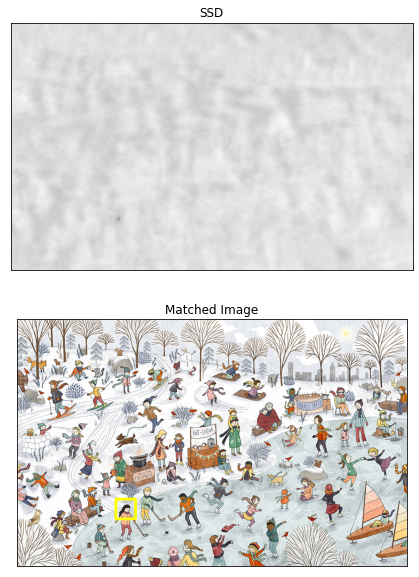

In [22]:
ref_img = get_img('find_me_image.jpg')
template = get_img('template.jpg')
template_matching(ref_img, template)

### match on noisy template

call the function with noisy template

Min SSD at: (459, 251)


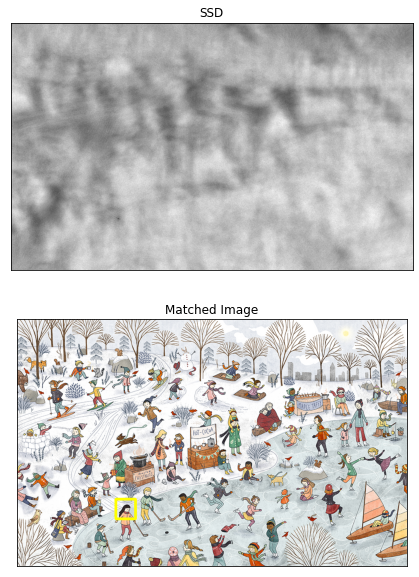

In [18]:
noisy_template = get_img('template_noisy.jpg')
template_matching(ref_img, noisy_template)